<a href="https://colab.research.google.com/github/alexiamhe93/goldStandard-tutorial/blob/main/Tutorial_2_Rule_based_dictionary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Building a rule-based dictionary classifier

Authors: Goddard, A. & Gillespie, A.

Date: January 2023

In this tutorial notebook, we use Python to run and validate a rule-based classifier on a dataset of sentences coded for misunderstandings. The sentences were produced in naturally occuring online dialogues, sourced from Reddit, Twitter, and Wikipedia Talk Pages.

The tutorial primarily uses the spaCy (Honnibal et al., 2022) package's rule-based matcher (https://spacy.io/usage/rule-based-matching) for applying the dictionary to a text. 

The tutorial provides instructions on how to:

1.   Build a set of dictionary items and prepare them for use in spaCy
2.   Run a rule-based classifier on a training dataset
3.   Troubleshoot the classifier predictions on the training dataset
4.   Validate the classifier on a validation dataset

References:

Honnibal, M., Montani, I., Van Landeghem, S., & Boyd, A. (2022). *spaCy: Industrial-strength natural language processing in Python*. Explosion.

## What is a rule-based dictionary classifier? 

A rule-based dictionary classifier measures the presence of a target construct in a text based on the presence of dictionary items. The most basic dictionary items are a list of words whose frequency is counted in every target text. Consider a very simple example where we are interested in finding out the degree of happiness in the following sentences:

> `S1 = "I can't stop smiling, I'm just so happy."` 

> `S2 = "This brings me joy."` 

> `S3 = "I'm panicking, I don't know what to do."` 

We then use the following dictionary to identify the degree of happiness in each sentence:

> `Happiness = ["happy", "joy", "smiling"]` 

The classifier then counts the frequency of the dictionary words across the three sentences, generating the following results:

> `Happiness(S1) = 2` 

> `Happiness(S2) = 1` 

> `Happiness(S3) = 0` 

The classifier could also generate a ratio of happiness words to the total number of words in the sentence:

> `Ratio(S1) = Happiness(S1)/TotalWords(S1) = 2/7 = 0.29` 

> `Ratio(S2) = Happiness(S2)/TotalWords(S2) = 1/4 = 0.25`  

> `Ratio(S3) = Happiness(S3)/TotalWords(S3) = 0/8 = 0`  

# Install packages

**NOTE: This cell should be run before running any other cell**

In [ ]:
# spaCy "medium" word-vector model for parsing sentences into tokens
!python -m spacy download en_core_web_md

# Load and prepare data for analysis

In this section, we load in the gold-standard dataset (i.e. a dataset manually coded for misunderstandings) which will be used to validate and troubleshoot the classifier's performance. 


## Load packages

In [1]:
# for downloading data
import requests, zipfile, io
# for setting directory
import os 
from pathlib import Path
# for mathematical / vectoral operations
import numpy as np
# for loading dataframes and spreadsheets (.csv)
import pandas as pd

## Load data from directory

This cell downloads the gold standard dataset from github and unzips it.

In [2]:
r = requests.get( 'https://github.com/alexiamhe93/goldStandard-tutorial/blob/main/Data/Tutorial-data.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

This cell loads the gold standard dataset into a dataframe.

In [3]:
df0 = pd.read_csv("Tutorial-data/Full_misunderstandings_data.csv")

In [4]:
# gives us the number of rows in loaded dataset
print(f"The full dataset contains {len(df0)} sentences coded for misunderstanding.")

The full dataset contains 21994 sentences coded for misunderstanding.


## Clean text data for analysis

The below cell runs a simple cleaning protocol over the data, selecting only relevant columns for the analysis, renaming columns where appropriate, removing any empty or numeric values in the text column, and deleting any rows which were not coded for 1 or 0 in the misunderstanding column.

In [5]:
# Select relevant columns for analysis
df0 = df0[["turn_id", "dialogue_id", "turn", "text", "Misunderstanding"]]
# delete any rows with no text
df0 = df0[df0["text"] != ""]
# delete all na rows with no text
df0 = df0[df0['text'].notna()]
# delete any numerical rows with no text
df0 = df0[~df0['text'].str.isnumeric()]
# delete all values for misunderstanding not equal to zero or one
df0 = df0[df0["Misunderstanding"].isin([0,1])]
# gives us the number of rows in loaded dataset after the cleaning process
print(f"The full dataset contains {len(df0)} sentences after cleaning.")

The full dataset contains 21982 sentences after cleaning.


The cleaning process resulted in 12 rows removed. We can check the first five rows of the dataset to see if they appear as we expect them to:



In [6]:
# inspect dataframe
df0.head()

,turn_id,dialogue_id,turn,text,Misunderstanding
0,tid_50,group_101723,turn_1,CMV: Territorial integrity should be taken les...,0
1,tid_50,group_101723,turn_1,"However, in my opinion, the insistence on part...",0
2,tid_50,group_101723,turn_1,Take the Western Brownberg as an example.,0
3,tid_50,group_101723,turn_1,An independent state in the region has no prec...,0
4,tid_50,group_101723,turn_1,The basis of such claims is that the Spanish u...,0


## Split dataset into training and validation datasets

In this section, we randomly split our data into a training dataset (70%) and a validation dataset (30%). This allows us to develop a classifier on the training set. We do this by running the classifier on the training data, observing the results, and making adjustments to the dictionary items. So long as we do not use the validation data during this stage, we can alter the classifier as many times as we need without fear of biasing the results.

In this section, we also stratify the data so that the frequency of misunderstandings is the same for both training and validation datasets. This is important for highly imbalanced datasets (such as the one used here) as we want to ensure enough of the positive class of the target variable in the validation set.

In [ ]:
# for splitting dataset into train and test sets
from sklearn.model_selection import train_test_split
# create vectors of texts from loaded dataset
sentences = df0['text'].copy()
# create vector of misunderstanding codes from loaded dataset
misunderstanding_codes = df0['Misunderstanding'].astype(int).copy()

# Split dataset
training_sentences, validation_sentences, training_codes, validation_codes = train_test_split(sentences, # text vector
                                                                                              misunderstanding_codes, # codes vector
                                                                                              test_size=0.30, # size of validation set (30%)
                                                                                              random_state=10, # random seed for replicating random split
                                                                                              stratify=misunderstanding_codes) # stratification by the codes vector

# Create train dataframe, ensuring codes are integers for the ktrain.text function
Training_df = pd.DataFrame({"text": training_sentences, "Misunderstanding": [int(x) for x in training_codes]})
# Create validation dataframe, ensuring codes are integers for the ktrain.text function
Validation_df = pd.DataFrame({"text": validation_sentences, "Misunderstanding": [int(x) for x in validation_codes]})

# Create dictionary items

In this section, we load in two spreadsheets used for creating our dictionary items. The first spreadsheet loads raw items into the dataset, while the second spreadsheet provides a list of synonyms and wildcards to generate multiple permutations of the original items.

## Load packages used

In [ ]:
# SpaCy's rule based matcher
from spacy.matcher import Matcher
# SpaCy's medium language model 
import en_core_web_md
# for counting values in a list/array
from collections import Counter 
# for displaying remaining time in a loading bar
from tqdm import tqdm 
# for accuracy statistics
from sklearn.metrics import classification_report
# load nlp() from SpaCy
nlp = en_core_web_md.load()

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


## Load in dictionary spreadsheets

In [ ]:
# Download dictionaries from github
r = requests.get( 'https://github.com/alexiamhe93/goldStandard-tutorial/blob/main/Data/Dictionaries/Dictionaries.zip?raw=true' ) 
z1 = zipfile.ZipFile(io.BytesIO(r.content))
z1.extractall()

In [ ]:
# dictionaries map
dictionary = pd.read_csv("Dictionaries/Misunderstanding_dictionary.csv")
# dictionaries augmentation
aug_dictionaries = pd.read_csv("Dictionaries/Augmenting_dictionary.csv")

In [ ]:
print(f"There are {len(dictionary)} items in the misunderstandings dictionary before creating permutations.")

There are 192 items in the misunderstandings dictionary before creating permutations.


In [ ]:
# preview first five dictionary items:
dictionary.head()

,Misunderstanding
0,I [adverb] {misunderstood} {you}
1,{I've} [adverb] {misunderstood} {what} {you}
2,I {didn't} [adverb] {understand} {you}
3,I {haven't} [adverb] {understood} {you}
4,no {idea} {what} {you're}


## Augment dictionary with permutations

We can observe that the dictionary has three types of words included within it:

1.   Words with no brackets: indicates a permanent word that does not vary across permutations
2.   Words with square brackets: indicates a wild card word that can be replaced either by any value in a list of words or no word at all
3.   Words with curly brackets: indicates a permanent word that is to be replaced by a list of synonyms. 

As an illustrative example, consider the first item in the dictionary: 

> `I [adverb] {misunderstood} {you}` 

We use the following (simplified) dictionaries to create permutations on the sentence:

> `adverb = ["completely", "actually"]` 

> `misunderstood = ["misunderstood", "misinterpreted"]`

> `you = ["you", "your"]`

By inputting the permutation dictionary items into the target item, we generate the following permutations:


> `new_items = ["I misunderstood you", "I misunderstood your", "I completely misunderstood you", "I completely misunderstood your", "I actually misunderstood you", "I actually misunderstood your", "I misinterpreted you", "I misinterpreted your", "I completely misinterpreted you", "I completely misinterpreted your", "I actually misinterpreted you", "I actually misinterpreted your"]`

Using this simple protocol, we create 12 new items from a single item by replacing synonyms and adding wildcards.

### Convert misunderstanding dictionary and augmenting dictionaries into correct formats

In [ ]:
# convert dictionary to list
misunderstanding_items = dictionary["Misunderstanding"].to_list()

In [ ]:
# create dictionaries of synonyms and wildcards. 
# These are in the Python dict format: {"key":"values"}, as this is easier to process:

# Synonym dictionary
synonyms = aug_dictionaries[[c for c in aug_dictionaries.columns.values if "{" in c]]
# convert to dictionary format
synonyms_dict = {}
for col in synonyms.columns:
  synonyms_dict[col] = synonyms[col].dropna().to_list()

# Wild card dictionary
wild_cards = aug_dictionaries[[c for c in aug_dictionaries.columns.values if "[" in c]]
# convert to dictionary format
wild_cards_dict = {}
for col in wild_cards:
  wild_cards_dict[col] = wild_cards[col].dropna().to_list() + [""] # add empty space necessary for deleting the wild card type

### Define functions for augmenting the items.

These functions are used to create all of the different permutations in the dictionary items. The first function creates new items by iterating once across the permutation dictionaries. The second function iterates over the first function until all permutations have been created and no words with square or curly brackets remain in the items. 

In [ ]:
# create functions to map on synonyms/wildcards

# this function replaces the dictionary words only once
def dictionary_augmenter(item, target_dict, wildcard = False):
  # check if item needs processing
  if ("{" not in item) & ("[" not in item):
    return [item]
  else:
    # create output list
    new_items = []
    # iterate over dictionary keys and values
    for k,v in target_dict.items():
      # if the word (key) is in the target item
      if k in item:
        # for every synonym in the values
        for v_ in v:
          # create a new item
          out_item = item.replace(k, v_)
          # if a wildcard item, remove any double spaces
          if wildcard == True:
            out_item = out_item.replace("  ", " ")
          # add new item to output list of items
          new_items.append(out_item)
    # return output      
    return new_items

# iterates over previous function until all items have been replaced

def synonym_augmenter(item, target_dict, wildcard = False):
  if ("{" not in item) & ("[" not in item):
    return [item]
  else:
    # run previous function and create initial list of augmented items
    item_list = dictionary_augmenter(item, target_dict, wildcard)
    # extract items (dependent on if synonyms or wild cards) that have no brackets
    if wildcard == True:
      good_items = [i for i in item_list if "[" not in i]
    else:
      good_items = [i for i in item_list if "{" not in i]
    # create a string of all items to test if any brackets remaining in items
    itemstring = ' '.join(item_list)
    # check if any synonyms to replace
    if "{" in itemstring:
      # iterates over the item list until all synonyms have been replaced
      while "{" in itemstring:
        # create new items for each item in the initial list of augmented items
        item_list = [dictionary_augmenter(i, target_dict, wildcard) for i in item_list]
        # flatten list of list
        item_list = [y for x in item_list for y in x]
        # add all clean items to final list (dependent on if synonyms or wild cards) 
        if wildcard == True:
          good_items = good_items + [i for i in item_list if "[" not in i]
        else:
          good_items = good_items + [i for i in item_list if "{" not in i]
        # create a new string of all items to check if any brackets remaining.
        # If any items still have a bracket, the loop will repeat. 
        itemstring = ' '.join(item_list)
      # return the final list of items
      return item_list + good_items
    else:
      return good_items

### Augment list of items with all permutations

In [ ]:
# augment the understanding dictionary by looping the new function over every sentence
augmented_misunderstanding_items = [synonym_augmenter(s, synonyms_dict) for s in misunderstanding_items] 
# flatten list of lists
augmented_misunderstanding_items = [y for x in augmented_misunderstanding_items for y in x]

# repeat for the wildcards
augmented_misunderstanding_items = [synonym_augmenter(s, wild_cards_dict, wildcard=True) for s in augmented_misunderstanding_items]
augmented_misunderstanding_items = [y for x in augmented_misunderstanding_items for y in x]

# delete any duplicates emerging during the permutation process
augmented_misunderstanding_items = list(set(augmented_misunderstanding_items))
print(f"there are {len(augmented_misunderstanding_items)} items in the augmented misunderstanding dictionary.")

there are 210245 items in the augmented misunderstanding dictionary.


## Create spaCy patterns from augmented items

We have now created a list of 210,245 augmented items. In this subsection, we put them in a format for use with the spaCy rule-based matcher.

The spaCy patterns expect a Python dictionary of tokens indicating how they should be searched for. The general pattern is as follows:

> `"I don't get your point."` becomes: `{{"LOWER":"I"}, {"LOWER": "do"}, {"LOWER": "n't"}, {"LOWER": "get"}, {"LOWER":"your"}, {"LOWER": "point"}, {"IS_PUNCT":True}}`

The spaCy patterns expect collocations to be split (`don't` into `do` and `n't`) and any punctuation to be input by the `IS_PUNCT` command.

### Define function to create spaCy patterns

In [ ]:
def createPattern(item, # expects a dictionary item as a string
                  nlp): # expects SpaCy NLP 
  # output list
  out_pat = []
  # create spacy document from item
  doc = nlp(item)
  # for every token in the document
  for t in doc:
    # let x be the lowercase token
    x = t.text.lower()
    # if the token is punctuation:
    if t.dep_ == "punct":
      # add punctuation pattern to output list
      out_pat.append({"IS_PUNCT":True})
    else:
      # if not punctuation, return the pattern for a lowercase word
      out_pat.append({"LOWER":x})
  return out_pat

### Run the function across all dictionary items to create a list of spaCy patterns

> **NOTE** For large dictionaries (such as this one) this function can take a long time to run (> 30 minutes).

In [ ]:
# output list for misunderstanding patterns
misunderstanding_patterns = []
# for each phrase in the dictionary
for x in tqdm(augmented_misunderstanding_items): 
  # create pattern from phrase and add to output list
  misunderstanding_patterns.append(createPattern(x, nlp))

100%|██████████| 210245/210245 [37:32<00:00, 93.33it/s]


# Run classifier on training set & troubleshoot results

The following section runs the dictionary on the training dataset. The results of this stage allows the user to troubleshoot any problems in the result.

## Run classifier and generate a column of results

In [ ]:
# function for generating pattern matches

def create_matches(df, # expects dataframe
                   patterns, # expect list of patterns
                   patterns_tag, # expects string - variable name
                   nlp, # expects SpaCy nlp()
                   text_col = "text"): # name of text column - default = "text"
  df["doc"] = [nlp(d) for d in df[text_col]]
  # initiate the pattern matcher
  matcher = Matcher(nlp.vocab)
  # add patterns to the matcher
  matcher.add(patterns_tag, patterns)
  # output list
  output = []
  # for document in document column
  for doc in tqdm(df.doc):
    # create matches
    matches = matcher(doc)
    # count matches
    counts = Counter(element[0] for element in matches)
    # update output list with frequency counts for document
    value = None
    for entry in counts:
        value = counts[entry]
    output.append(value)
  # create output column of matches
  df[patterns_tag] = output
  # fill no matches (nan) with zero
  df[patterns_tag] = df[patterns_tag].fillna(0)
  # return dataframe
  return df

# function for making a frequency vector binary 
def binaryMaker(list_):
  out = []
  for x in list_:
    if x > 0:
      out.append(1)
    else:
      out.append(0)
  return out

In [ ]:
# Get frequency count for results
Training_df = create_matches(Training_df, misunderstanding_patterns, "Misunderstanding_predicted", nlp)
# convert frequency count to a binary variable
Training_df["Misunderstanding_predicted"] = binaryMaker(Training_df["Misunderstanding_predicted"].tolist())

100%|██████████| 15387/15387 [1:02:04<00:00,  4.13it/s]


## Check accuracy of classifier results

To assess the accuracy of the results, we first generate a **confusion matrix** that shows the true/false positives and negatives for the classifier. A true positive is where the predicted code equals 1 and the gold-standard code equals 1; a true negative is where the predicted code equals 0 and the gold-standard code equals 0; a false positive is where the predicted code equals 0 but the gold-standard code equals 1; and, finally, a false negative is where the predicted code equals 1 but the gold-standard code equals 0. 

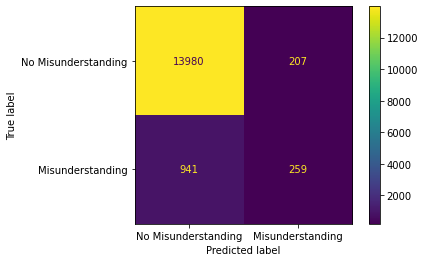

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# create confusion matrix
cm = confusion_matrix(Training_df["Misunderstanding"].tolist(), Training_df["Misunderstanding_predicted"].tolist())
# plot the results
disp = ConfusionMatrixDisplay(cm, display_labels = ["No Misunderstanding", "Misunderstanding"])
disp.plot()
plt.show()


Using the true/false positives/negatives, we can generate four accuracy statistics to estimate the performance of the classifier:

*   Accuracy: the ratio of correct predictions 
*   Precision: the ratio of true positives to true positives and false positives
*   Recall: the ratio of true positives to true positives and false negatives
*   F1 score: harmonic mean of precision and recall

In [ ]:
print(classification_report(Training_df["Misunderstanding"].tolist(), Training_df["Misunderstanding_predicted"].tolist()))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     14187
           1       0.56      0.22      0.31      1200

    accuracy                           0.93     15387
   macro avg       0.75      0.60      0.64     15387
weighted avg       0.91      0.93      0.91     15387



## Troubleshoot results

We observe from our results that the classifier is performing poorly for correctly identifying misunderstandings in the gold-standard dataset. The classifier has higher precision (0.56) than recall (0.22), indicating that it is better at identifying misunderstandings correctly than identifying misunderstandings generally. This is verified by observing the number of false positives (n=207) and false negatives (n=941) in the confusion matrix. 

> **NOTE**: Using only the accuracy statistic for validation obscures the classifier's poor performance (Accuracy = 0.93). As the majority class is 0 (i.e. not misunderstandings), the classifier would perform relatively well by classifying most texts into the majority class. The F1, Precision, and Recall statistics for predicting the minority class (i.e. misunderstandings) provide a more robust indication of the classifier's performance.

To troubleshoot the classifier results, it is necessary to examine both the false negatives and false positives. The false negatives give an insight into the classifier's recall while the false positives give an insight into the classifier's precision. We use a combination of three methods to explore the classifier's performance:

1. Qualitative assessment of false negatives/positives. This indicates how the classifier is treating the raw texts from the gold-standard dataset.

2. Look at the most frequently co-occuring words for false negatives/positives. This provides us patterns from the results that can be used to remove or add items as required.

3. Look at the unique co-occuring words for the false negatives. This provides patterns that are unique to the target variable (i.e. misunderstandings).

### Qualitative assessment of false positives and false negatives

In [ ]:
# for fetching a random sample
import random

# function to identify false positives or negatives
def generate_n_false_pos_or_neg(df, # dataframe with predictions
                                true_col, # column with gold-standard codes
                                predicted_col, # column with codes generated by classifier
                                target="FP", # target - false negatives or false positives. Default = false positives
                                n_examples =50, # number of examples to generate. Default = 50
                                text_col = "text"): # name of text column - default = "text"
  # get full list of false negatives
  false_negatives = df[(df[true_col]==1) & (df[predicted_col] == 0)]["text"].to_list()
  # get full list of false positives
  false_positives = df[(df[true_col]==0) & (df[predicted_col] == 1)]["text"].to_list()
  # create random sample for output
  if target == "FP":
    output = random.sample(false_positives, n_examples)
  elif target == "FN":
    output = random.sample(false_negatives, n_examples)
  else:
    print("WARNING: Please input target as 'FN' for false negatives or 'FP' for false positives")
    output = []
  # return random sample
  return output

#### False negatives example sentences

Observing the raw text of the false negatives gives an insight into what items are potentially missing from the classifier. For instance, the first sentence contains the phrase "i want to make sure i understood what u mean" which indicates a misunderstanding but is not being identified by the classifier. This is likely due to the use of the letter "u" instead of the second person pronoun which, under this version of the dictionary, is not being captured. A future version of the dictionary, therefore, might consider adding the letter "u" as a possible permutation of the word "you". 

> **NOTE** Researchers should avoid copy-pasting sentences from the false negatives directly into the dictionary items. This may improve the precision but creates overfitting, where the classifier is only able to predict the variable in the original data. Overfitting results in the classifier performing poorly when applied to new data. Instead, researchers should devise generalisable patterns from the false negatives that could logically apply across multiple texts. 

In [ ]:
generate_n_false_pos_or_neg(Training_df, "Misunderstanding", "Misunderstanding_predicted", target = "FN", n_examples = 10)

['about notability: i want to make sure i understood what u mean: r u saying that i wrote an article about something that does not exists and i need to prove its existence?',
 'Sorry about that, I had some real life stuff that was consuming much of my energy and did not do as much as I should have.',
 'Have you ever overstepped anything that was looked as "teens being teens" at the time?',
 "Deborah, we've not heard from you are you still experiencing log in issues?",
 'NOT believe ALL women.',
 'I was drawing attention to the points I particularly agreed with, and your submission was one of them.',
 "He wanted all three of us to vote, that's why I asked you.",
 'Since the issue has already been solved I see no need to explain it anywhere.',
 'Both, though I mean the former more.',
 'Thanks, Nicholas, not sure about this!']

#### False positives example sentences

Observing the raw text of the false positives provides aninsight into which items may be too broad and, therefore, capturing problematic items. For instance, the first sentence below contains the phrase "but what I'm saying is" which relates to an item in the current misunderstandings dictionary. While this phrase does indicate misunderstandings in some contexts, it can also refer to a grammatical hedge, where an individual is attempting to clarify or simplify something they have previously said in their comment (similar to the phrase "in other words" or "i.e."). Removing or making this item more specific – for instance "what I was saying above" – may improve the precision of the dictionary and prevent a false positive.

In [ ]:
generate_n_false_pos_or_neg(Training_df, "Misunderstanding", "Misunderstanding_predicted", target = "FP", n_examples = 10)

["To be clear, I know this is not a black and white issue, but what I'm saying is that if you add it all up, religion has not helped our society improve more than it could have if we just acted treated everyone with love and left our planet better than we found it.",
 'Sir, if you are not going to undelete the page, I have no other choice than to bring the matter to [[WP:DELETION REVIEW]].--',
 'Glad I got my part correct and that the system works.',
 "I'm not sure what happened to the dashes during that crazy day.",
 'You know how when you try to look through a window at a very slight angle you only see reflection?',
 'I am from the [[Jonesport]] (if that\'s what you mean by \\"Midland\\") and no one in my town pronounces the vowel sound in words like \\"row\\" the same way a southerner would.',
 'upvoted you because idk who the hell downvoted you or why they did.',
 'I had trouble coming up with a title that actually stated a particular point that could be argued against, but I am op

### Find most frequent ngrams

A sentence can be split into varying chuncks of co-occuring words. We refer to these co-occuring words as "ngrams".  To illustrate, consider the phrase: `"I don't understand you"`. We can generate three bigrams from the phrase: `"I don't", "don't understand", "understand you"`, two trigrams: `"I don't understand", "don't understand you"`, or a single quadgram: `"I don't understand you"`. 

The below function and cells generates the most frequently occuring ngrams for a list of texts. We can use the functions from the previous subsections for generating false positves and negatives and then use these to generate ngrams.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

def get_top_ngrams_from_texts(list_of_texts, # input list of texts
                              ngram_size = 3, # size of ngram. Default = trigram
                              n_examples = 50): # number of examples to generate. Default = 50
  # prime the vectorizer from sklearn that will generate all ngrams of the input ngram size
  vectorizer = CountVectorizer(ngram_range=(ngram_size,ngram_size))
  analyzer = vectorizer.build_analyzer()
  # create empty list to populate with ngrams
  output_ngrams = []
  # iterate over list of texts and add ngrams for each text to the output list
  for text in list_of_texts:
    output_ngrams = output_ngrams + analyzer(text)
  # count frequency of each ngram and put into a dataframe
  outdf = pd.DataFrame.from_dict(Counter(output_ngrams), orient = "index").reset_index()
  outdf = outdf.rename(columns = {"index": "Text", 0: "Count"})
  # sort dataframe by highest occuring ngrams
  outdf = outdf.sort_values("Count", ascending = False)
  # return n_examples of highest occuring ngrams
  outdf = outdf.head(n_examples)
  return outdf

In [ ]:
# create list of false positives and false negatives from training dataset
false_negatives = generate_n_false_pos_or_neg(Training_df, "Misunderstanding", "Misunderstanding_predicted", target = "FN", n_examples = 941)
false_positives = generate_n_false_pos_or_neg(Training_df, "Misunderstanding", "Misunderstanding_predicted", target = "FP", n_examples = 207)

#### Most frequent trigrams for false negatives

The most frequent false negatives ngrams gives an insight into common patterns that may be useful to derive and create new items. Unlike the raw sentences, observing ngrams provide the researcher with indicators of potential patterns. For instance, the phrase "sorry about that" might become an additional item for the dictionary and improve the classifier's recall.

In [ ]:
get_top_ngrams_from_texts(false_negatives, ngram_size =3, n_examples = 10)

,Text,Count
1890,the talk page,9
1889,on the talk,9
3241,that it is,7
1252,index php title,7
1251,org index php,7
1250,wikipedia org index,7
1249,en wikipedia org,7
1248,http en wikipedia,7
760,that you are,6
1147,sorry about that,5


#### Most frequent trigrams for false positives

In contrast to the most frequent false negative ngrams, the most frequent false positive ngrams provide general patterns which the classifier may be incorrectly using to identify the target variable. For instance, in the below example, the trigram "you re not" ("you're not") is the most frequent trigram. The dictionary items therefore might be improved by identifying instances where "you're not" is being used to identify a text as a misunderstanding.

In [ ]:
get_top_ngrams_from_texts(false_positives, ngram_size =3, n_examples = 10)

,Text,Count
256,you re not,12
1437,to do with,9
139,if it was,9
31,you are not,8
186,you think it,7
1436,nothing to do,6
963,if you are,5
805,can you tell,5
1624,do with the,5
0,not sure what,4


### Find unique ngrams

This function generates unique ngrams for the target list that are not in another list. For instance, if `target_list` is the false negatives and the `not_list` the false positives, it will generate all ngrams unique to the false negatives.

In [ ]:

def get_unique_ngrams_for_list(target_list, # list to find unique ngrams
                               not_list, # list to check whether ngrams are unique to the target list
                               ngram_size = 3, # size of ngram. Default = trigram
                               n_examples = 50): # number of examples to generate. Default = 50
  # prime the vectorizer from sklearn that will generate all ngrams of the input ngram size                            
  vectorizer = CountVectorizer(ngram_range=(ngram_size,ngram_size))
  analyzer = vectorizer.build_analyzer()
  # get the ngrams for the target list
  output_ngrams1 = []
  for text in target_list:
    output_ngrams1 = output_ngrams1 + analyzer(text)
  # get the ngrams for the not list
  output_ngrams2 = []
  for text in not_list:
    output_ngrams2 = output_ngrams2 + analyzer(text)
  # remove duplicates from both target and not list
  set_output_ngrams1 = list(set(output_ngrams1))
  set_output_ngrams2 = list(set(output_ngrams2))
  # get the output list of unique ngrams for the targt list
  out_list = [i for i in set_output_ngrams1 if i not in set_output_ngrams2]
  # count frequency of each ngram in the target list ngrams and put into a dataframe
  outdf = pd.DataFrame.from_dict(Counter(output_ngrams1), orient = "index").reset_index()
  outdf = outdf.rename(columns = {"index": "Text", 0: "Count"})
  # only keep the ngrams in the list of unique ngrams
  outdf = outdf[outdf["Text"].isin(out_list)]
  # sort dataframe by most frequent ngrams
  outdf = outdf.sort_values("Count", ascending = False)
  # return n_examples of highest occuring unique ngrams
  outdf = outdf.head(n_examples)
  return outdf

#### Unique trigrams for false negatives

Identifying the unique trigrams for the false negatives provides us with possible patterns for identifying new items for the dictionary. For instance "sorry about that" appears as a unique trigram as well as one of the most frequent trigrams overall for the false negatives. We can therfore add it to the dictionary with confidence that it discriminates texts containing misunderstandings from those containing no misunderstandings.

In [ ]:
get_unique_ngrams_for_list(false_negatives, false_positives, ngram_size = 3, n_examples = 10)

,Text,Count
3241,that it is,7
1250,wikipedia org index,7
1248,http en wikipedia,7
1251,org index php,7
1252,index php title,7
1249,en wikipedia org,7
760,that you are,6
1147,sorry about that,5
3461,let me know,4
3435,whether or not,4


# Validate dictionary using validation dataset

Validating the dictionary should only be performed *after the final dictionary items have been created*. This is because we do not want to transfer any biases from the items introduced from troubleshooting the dictionary on the training dataset. Keeping the training and validation dataset separate allows for an iterative process of creating the dictionary items on the training dataset. 




## Run dictionary on validation set

In [ ]:
# Get frequency count for results
Validation_df = create_matches(Validation_df, misunderstanding_patterns, "Misunderstanding_predicted", nlp)
# convert frequency count to a binary variable
Validation_df["Misunderstanding_predicted"] = binaryMaker(Validation_df["Misunderstanding_predicted"].tolist())

100%|██████████| 6595/6595 [28:54<00:00,  3.80it/s]


## Get final accuracy assessment for dictionary validation 

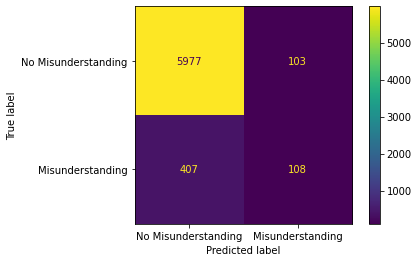

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# create confusion matrix
cm = confusion_matrix(Validation_df["Misunderstanding"].tolist(), Validation_df["Misunderstanding_predicted"].tolist())
# plot the results
disp = ConfusionMatrixDisplay(cm, display_labels = ["No Misunderstanding", "Misunderstanding"])
disp.plot()
plt.show()

In [ ]:
print(classification_report(Validation_df["Misunderstanding"].tolist(), Validation_df["Misunderstanding_predicted"].tolist()))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6080
           1       0.51      0.21      0.30       515

    accuracy                           0.92      6595
   macro avg       0.72      0.60      0.63      6595
weighted avg       0.90      0.92      0.91      6595



# Conclusion

This notebook has demonstrated how to use a gold-standard dataset to troubleshoot and validate a rule-based dictionary classifier. We provided instructions on how to create a list of augmented dictionary items based on a set of seed phrases and synonym dictionaries and wild cards. We then used spaCy's rule-based-matcher to run the classifier on the training dataset. We proceeded to generate accuracy statistics for the training dataset and, based on these results, used false positives/negatives to troubleshoot the classifier's performance. Finally, we ran the classifier on the validation dataset with the final dictionary items. 

The dictionary performs poorly on both the training (F1 = 0.31) and validation datasets (F1 = 0.30), despite having more items (n=210,245) than there are coded texts (n=21,982). This highlights a limitation to using phrases as dictionary items. Even when accounting for multiple permutations on a phrase, humans can express themselves in an almost unlimited number of ways. A human coder may be able to recognize misunderstandings from raw text, identifying patterns without having to formalise them. The rule-based classifier, however, must formalise these patterns into an exhaustive list and account for unseen patterns. 

Despite this limitation, using a gold-standard dataset for refining and troubleshooting a rule-based dictionary classifier's performance appears effective. The performance of the classifier on both the training and validation sets are very similar (in terms of precision, recall and F1-score). This means that the classifier is adequately performing on data unseen by the researcher during the training phase. 